### Volatility Forecasting with GARCH/ISD
Vineet Apte

In [1]:
from datetime import date,timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
import math
import scipy.linalg as la
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

### Introduction

The global financial crisis of 2008 led practitioners and academics alike to reassess
the adequacy of financial models. In particular, a new focus was given to the concept of volatility. Volatility is a measure of the movement in an asset's returns over time. 

In this notebook we explore the following  models, each of which represents a different approach to the volatility forecasting problem. 

1. The theoretical approach:  Generalized Autoregressive Conditional Heteroskedasticity (GARCH) 
2. The empirical approach: Implied Standard Deviation (ISD)


### Table of Contents

- [What is volatility? What does it matter?](#What-is-volatility?-Why-does-it-matter?)
- [Getting the data](#Getting-the-data)
- [GARCH](#GARCH)
- [Implied Standard Deviation](#Implied-Standard-Deviation)
- [Application: Volatility Arbitrage](#Application:-Volatility-Arbitrage)
- [Summary and References](#Summary-and-References)

### What is volatility? Why does it matter?

Let $A$ be an asset where $P_t$ is $A$'s price at time $t$ and $\displaystyle R_t = \log\frac{P_t}{P_{t-1}}$ is the 
daily return. We want to know the spread of the $R_t$'s distribution over time $0$ to $T$. We might compute $\displaystyle  \text{Var}(R_t) = \frac{1}{T-1}\sum_{i=0}^T (\bar{R}-R_i)^2$, the unbiased variance estimate of $R_t$ assuming returns are normally distributed. In practice however, we take these daily returns and define "annualized volatility" as $\displaystyle \sigma_{\text{annual}} = \frac{ \text{Var}(R_t) }{\sqrt{252}}$ as there are 252 trading days in a year. Annualized volatility is the key measure we will study in this notebook. 

The price of almost every derivative security is affected by swings in volatility. In particular, stock options are often priced based upon market participants' expectations of volatility in the underlying asset in the future. Risk management models used by financial institutions and required by regulators take time-varying volatility as a key input. As such, volatility forecasting is a key financial problem. 

### Getting the data

We're going to use the pandas DataReader module to fetch market data from Yahoo! Finance. In particular, we're going to see if we can forecast volatility on Microsoft (`MSFT`). Our data will be returned in the Open/High/Low/Close (OHLC) format : 

 |         **OHLC Schema**             | 
|----------|-------------|
| Open      | Price of stock at market open |
| High | Maximum price during trading day |
| Low | Minimum price during trading day |
| Close | Price at end of trading day |
| Adjusted Close | Close price adjusted for dividends/stock splits |

which is standard for equities market data feeds. We define a class `TimeSeries` for OHLC time series and implement `TimeSeries.build(ticker)`, a method to fetch it. 

In [2]:
class TimeSeries(object):
    '''
    Helper class for OHLC bar data
    '''
    def __init__(self,ticker=None):
        if ticker is not None:
            self.ticker=ticker.upper()
            print('Getting <'+self.ticker+'> OHLC')
            self.build()

    def vol(self,window=10):
        assert(type(window) is int)
        return self.log_ret(window).rolling(window=window).std()/math.sqrt(252)
    
    def build(self):
        '''Grab self.ts data from Yahoo Finance'''

        start,end  = date(2001,1,11),date.today()  #format is year,month,day
        start_str = '&a={month}&b={day}&c={year}'.format(year=start.year,month=start.month,day=start.day)
        end_str = '&d={month}&e={day}&f={year}'.format(year=end.year,month=end.month,day=end.day)
        params = ''
        url  = 'http://ichart.finance.yahoo.com/table.csv?s={ticker}{date}{params}&ignore=.csv'.format(ticker=self.ticker,
                                                                                                    date=start_str+end_str,
                                                                                                    params=params)
        self.ts = pd.read_csv(url)
        self.ts = self.ts.set_index('Date')
        self.ts = self.ts.sort_index()
        self.ts.index = pd.to_datetime(self.ts.index)
        self.ts.rename(columns = lambda z: z.lower(),inplace=True)
        self.ts.rename(columns = {'adj close':'ac'},inplace=True)

    def log_ret(self,window_len):
        return np.log(self.ts.ac/self.ts.ac.shift(window_len))

    def plot(self, *args,**kwargs):
        self.ts.plot(*args,**kwargs)

Note that the `ts` field contains the actual DataFrame obtained from Yahoo! Finance. 

Getting <MSFT> OHLC
               open     high      low    close    volume         ac
Date                                                               
2001-02-12  58.8125  59.4375  57.1875  58.7500  71289400  20.080435
2001-02-13  59.6250  61.0625  58.1250  58.1875  76070600  19.888176
2001-02-14  57.6250  59.0000  56.3750  58.3750  61728400  19.952262
2001-02-15  59.0000  60.1875  57.8750  58.8125  65627800  20.101797
2001-02-16  57.0000  58.2500  56.1250  57.3125  66958400  19.589105 



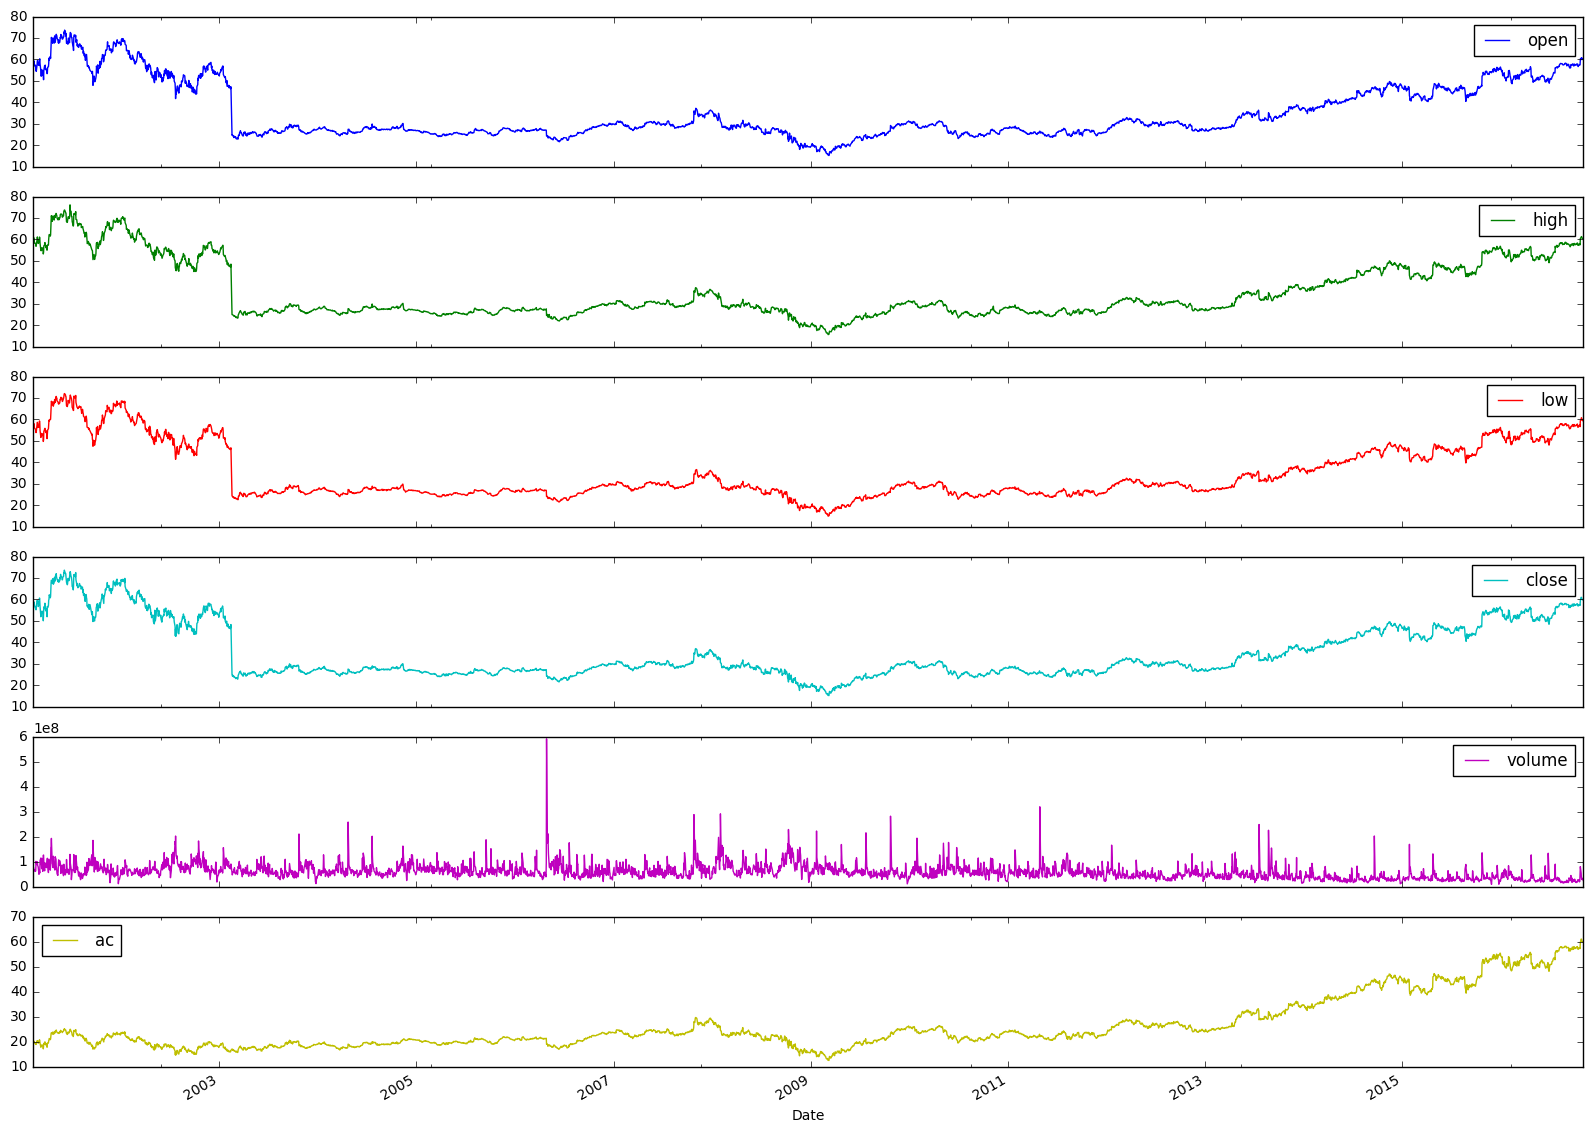

Log Returns
Date
2001-02-12         NaN
2001-02-13   -0.009621
2001-02-14    0.003217
2001-02-15    0.007467
2001-02-16   -0.025836
Name: returns, dtype: float64 

Daily Volatility
Date
2001-02-12         NaN
2001-02-13         NaN
2001-02-14         NaN
2001-02-15    0.000761
2001-02-16    0.001294
Name: vol, dtype: float64


In [3]:
msft = TimeSeries('MSFT')
print msft.ts.head(),'\n'

msft.ts.plot(subplots=True)
plt.show()

msft.ts['returns'] = msft.log_ret(1)
msft.ts['vol'] = msft.vol(2)

print 'Log Returns\n', msft.ts.returns.head(),'\n'
print 'Daily Volatility\n', msft.ts.vol.head()

We can see that the first few values in both the log returns and daily volatility time series are `NaN` as expected. It is a known empirical result that $R_t$ is normally distributed for most stocks that we will observe (you can read more about that here https://quantivity.wordpress.com/2011/02/21/why-log-returns/). This is one of the key assumptions of the GARCH model. 

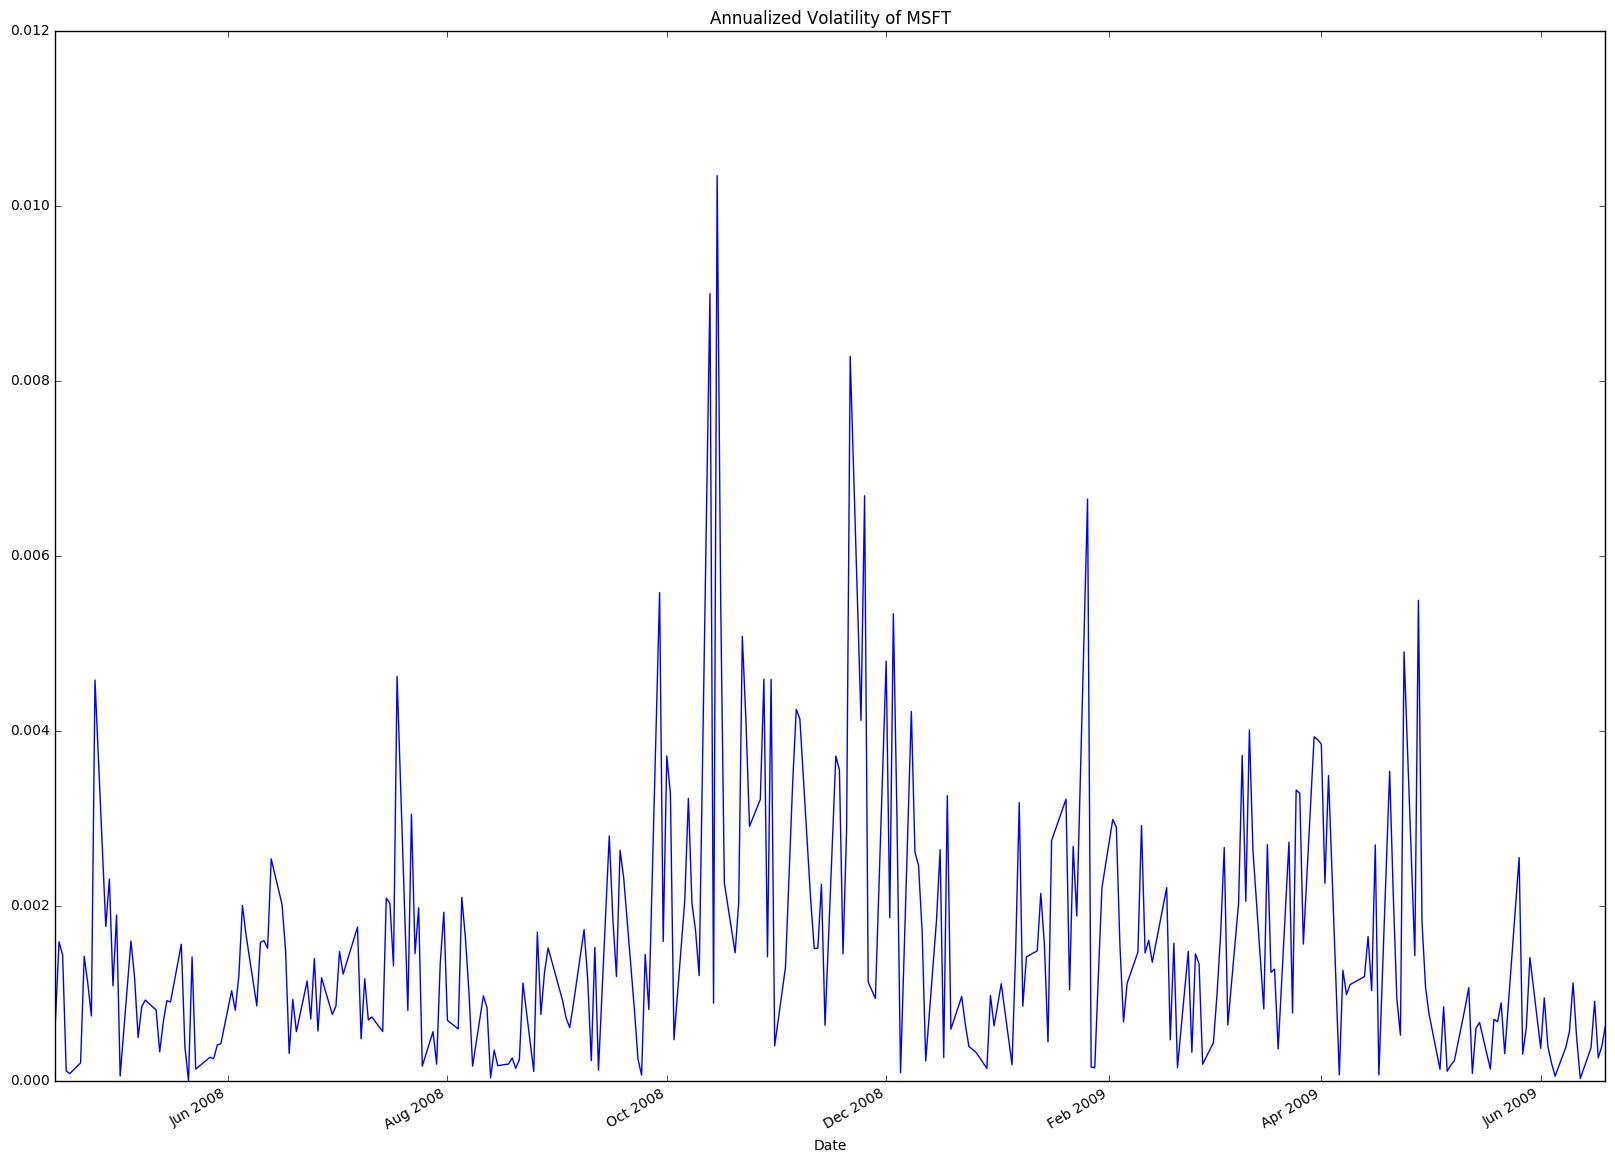

In [4]:
msft.ts.vol[1800:2100].plot(title='Annualized Volatility of MSFT')
plt.show()

Here we can see the characteristic mean-reverting pattern of each day's volatility (which we have "annualized" by dividing $\sqrt{252}$. There's also a spike in volatility around the end of 2008 (as one would expect). Our goal is make forecasts on this time series from one day to the next.  

### GARCH

The key recurrence used by the GARCH model is 
   
$ \sigma_t^2 = \omega + \alpha R_{t-1}^2 + \beta \sigma_{t-1}^2 $
    
based on the most recent update of $R$ and $\sigma$. $(\omega,\alpha,\beta)$ are parameters that we can determine with the maximum likelihood estimation (MLE) method. MLE, in the context of GARCH, looks for the maximum value of the sum where the $\sigma_i$'s are generated by GARCH with a "guess" value for $(\omega,\alpha,\beta)$.

$\sum_{i=1}^{N} \left[ -\log(\sigma_i^2) – \frac{R_i^2}{\sigma_i^2} \right]$ 

where $N$ denotes the length of the return series $\{R_t\}$ under study (we don't try to forecast $t=0$ for obvious reasons). 

We write a class, `GARCH`, that will be used in the MLE process. It contains two input parameters: `params` is a list with some trial values for $(\omega,\alpha,\beta)$ and `r` denotes the return series.

In [17]:
class GARCH:
    '''Implements GARCH(1,1) model'''

    def __init__(self,params,r):
        self.params = params
        self.r = r
        self.r2 = r**2
        self.vol2 = ((self.r-self.r.mean())**2)/len(self.r)
        self.omega,self.alpha,self.beta = [None]*3
    
    
    def fit(self):
        def log_likelihood(params, r):
            #function to be optimized
            omega, alpha, beta = params
            n = len(r)
            s = np.ones(n)*0.01
            s[2] = np.var(r[0:3])
            for i in range(1, n):
                s[i] = omega + alpha*r[i-1]**2 + beta*(s[i-1])  # GARCH(1,1) model
            log_l = -((-np.log(s) - r**2/s).sum())
            return log_l
        
        _optimized = optimize.fmin(log_likelihood,np.array(self.params), args=(self.r,), full_output=1)
        
        self.omega,self.alpha,self.beta = np.abs(_optimized[0])
        
    def predict(self,vol):
        return self.omega + self.alpha*self.r2.shift(-1) + self.beta*self.vol2.shift(-1)

We should check to see if our GARCH is accurate. Let's compute the root mean squared error: $\displaystyle\operatorname{RMSE}=\sqrt{\frac{\sum_{t=1}^n (\hat y_t - y_t)^2}{n}}$, where $\hat y_t$ is a prediction and $y_t$ is the actual value.

Optimization terminated successfully.
         Current function value: -23124.822905
         Iterations: 143
         Function evaluations: 280


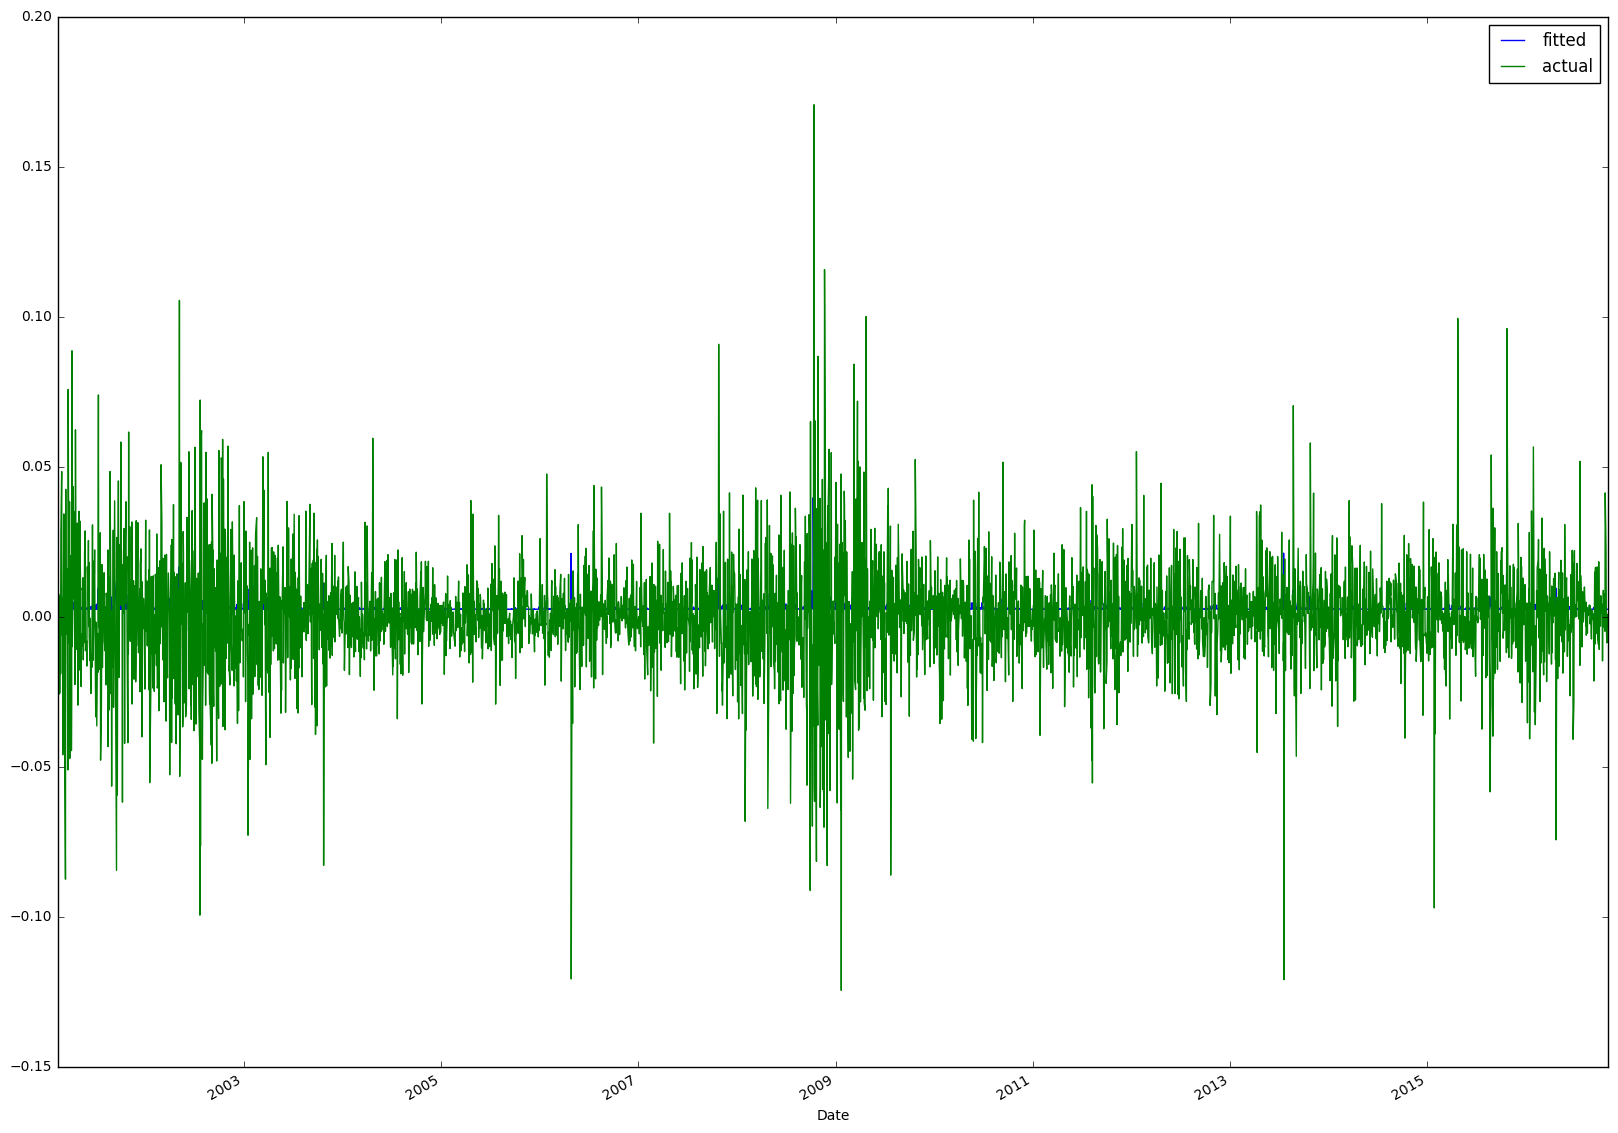

RMSE: 0.0184048491459


In [18]:
def compute_rmse(actual,predicted):
    squared_diff = (predicted-actual)**2
    return squared_diff, np.sqrt(float(squared_diff.sum())/float(len(squared_diff)))

g = GARCH([1,1,1],msft.ts.returns.dropna())
g.fit()

df = pd.DataFrame()
df['fitted'] = g.predict(g.r)
df['actual'] = g.r
df.plot()
plt.show()
squared_diff, error = compute_rmse(df.actual, df.fitted)
df['error'] = squared_diff
print "RMSE:",error
plt.show()

It appears that GARCH isn't as good as we thought. Most of the movement in the time series is not captured by this model. There are many possible reasons for why this could have occurred - the primary one being that we only tried to run GARCH for one particular ticker. 

There's no reason to worry, working through multiple models is routine in quantitative finance. GARCH is a pretty theoretical one, so let's see if a more empirical method will deliver better results.

### Implied Standard Deviation  

Options are contracts that permit one to buy or sell a security at a future time and price. 

For example, I could purchase an option conrtract on `MSFT` that let's me buy a 100 shares on December 10th at $\$43$. If, on December 10th, the price is $\$50$, I can buy a 100 shares at $\$43$ and immediately sell at $\$50$, accruing a tidy $\$50-\$43 = \$7$ profit per share (less the cost of the contract itself). The pricing of options is heavily reliant on volatility. 

In fact, the price of an option reflects the "implied volatility" of the underlying asset. 

Implied Standard Deviation (ISD) describes the class of methods that uses the "implied" volatility and price of options to make predictions on "realized" volatility in the future.

Instead of trying to predict the future volatilities ourselves, why not look at how the market prices in future volatility? The Chicago Board Options Exchange publishes the CBOE Volatility Index, or VIX for short. The VIX represents the market's expectation of stock market volatility over the next month (22 actual trading days). The VIX is calculated by examining future volatilities implied by the prices of S&P 500 options with about a month to expiration. The details of VIX calculation are a bit too technical, but you can read more here: https://www.cboe.com/micro/vix/vixwhite.pdf.

We can run a linear regression of VIX values against realized S&P 500 volatilities one month in the future to see if the market predictions are accurate. 


Getting <^VIX> OHLC


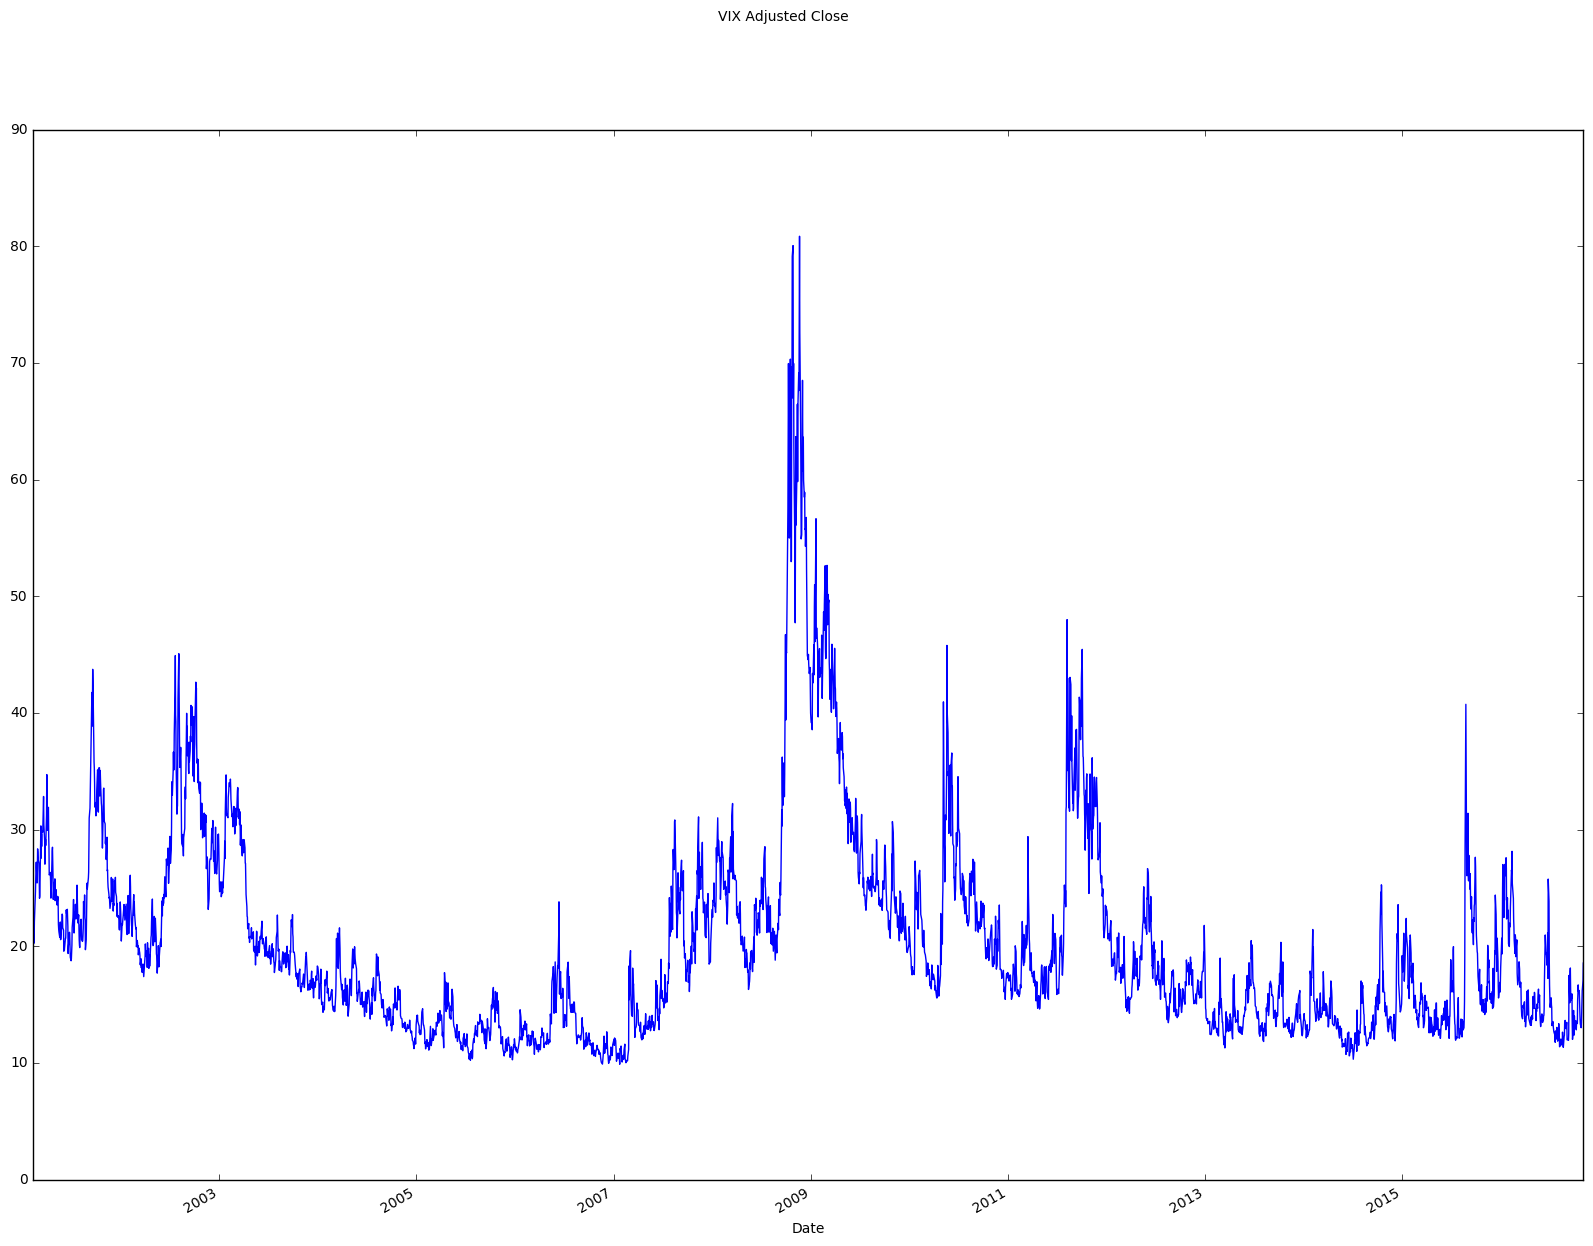

Getting <^SP500TR> OHLC


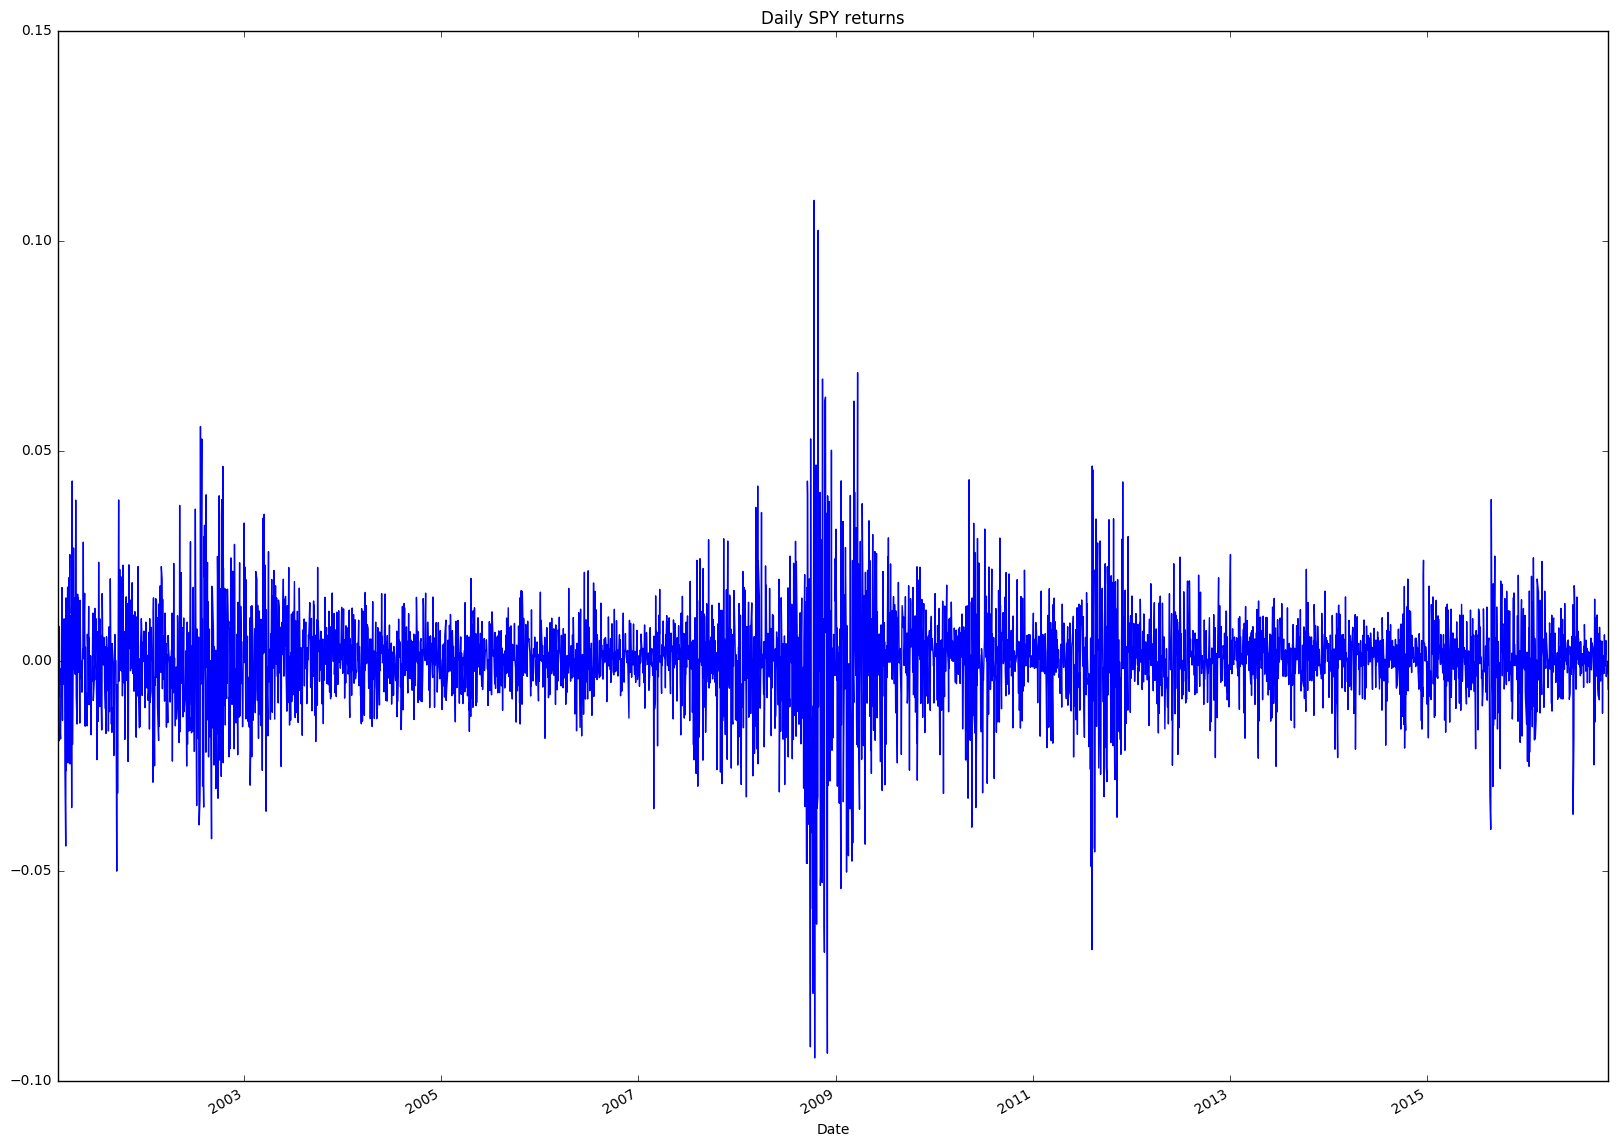

In [7]:
vix = TimeSeries('^VIX')
vix.ts.ac.plot(title = "VIX Adjusted Close",subplots=True)
plt.show()
spy = TimeSeries('^SP500TR') #S&P 500 tracker
spy.ts['returns'] = spy.log_ret(1)
spy.ts.returns.plot(title = "Daily SPY returns")
plt.show()

We'll use my implementation of the linear regression model from Homework 3. It would be nice to have an extra method for the coefficient of determination:

$\displaystyle R^2 = 1- \frac{\sum_t (y_t - \bar y)^2}{\sum_t (y_t - f(x_t))^2}$ 

where $f(x_t)$ is the predicted value for $y_t$ (the actual value) and $\bar y$ is the mean of $\{y_t\}$. 

In [8]:
class LR_model():
    
    def __init__(self, X, y):
        assert(len(X)==len(y))
        try:
            xtx = la.cho_factor(X.T.dot(X) + 1e-4*np.eye(X.shape[1]))
        except IndexError:
            xtx = la.cho_factor(X.T.dot(X) + 1e-4*np.eye(1))
        self.beta = la.cho_solve(xtx, X.T.dot(y))
        self.has_predicted=False
                
    def predict(self, X_p):
        self.test = X_p
        _res =  X_p * self.beta[0][0] #since we only look at one feature
        self.pred = _res
        self.has_predicted = True
        return _res
        
    def r_squared(self):
        if not self.has_predicted: print "Run on test data before calculating R^2"
        _num = ((self.test-self.test.mean())**2).sum()
        _denom = ((self.test-self.pred)**2).sum()
        return 1-(_num/_denom)  

We have to shift the SPY time series 22 days in the future before making our predictions:

R^2: 0.815360841529


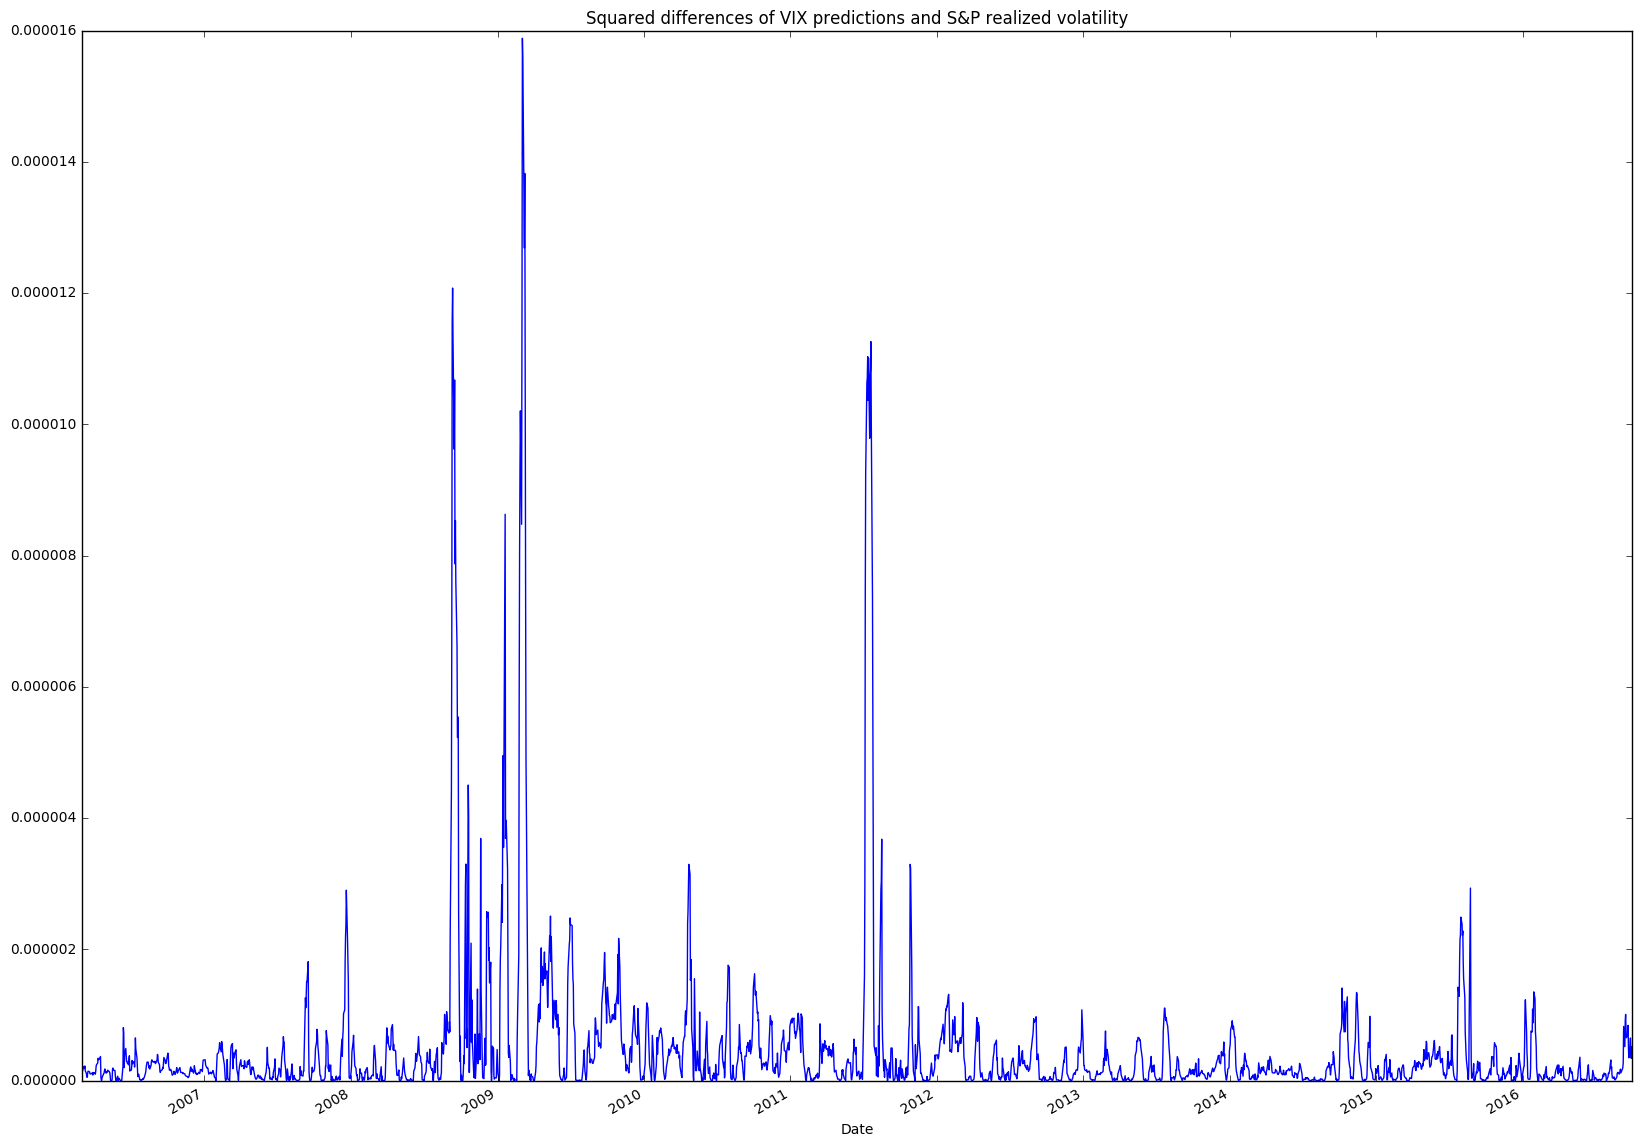

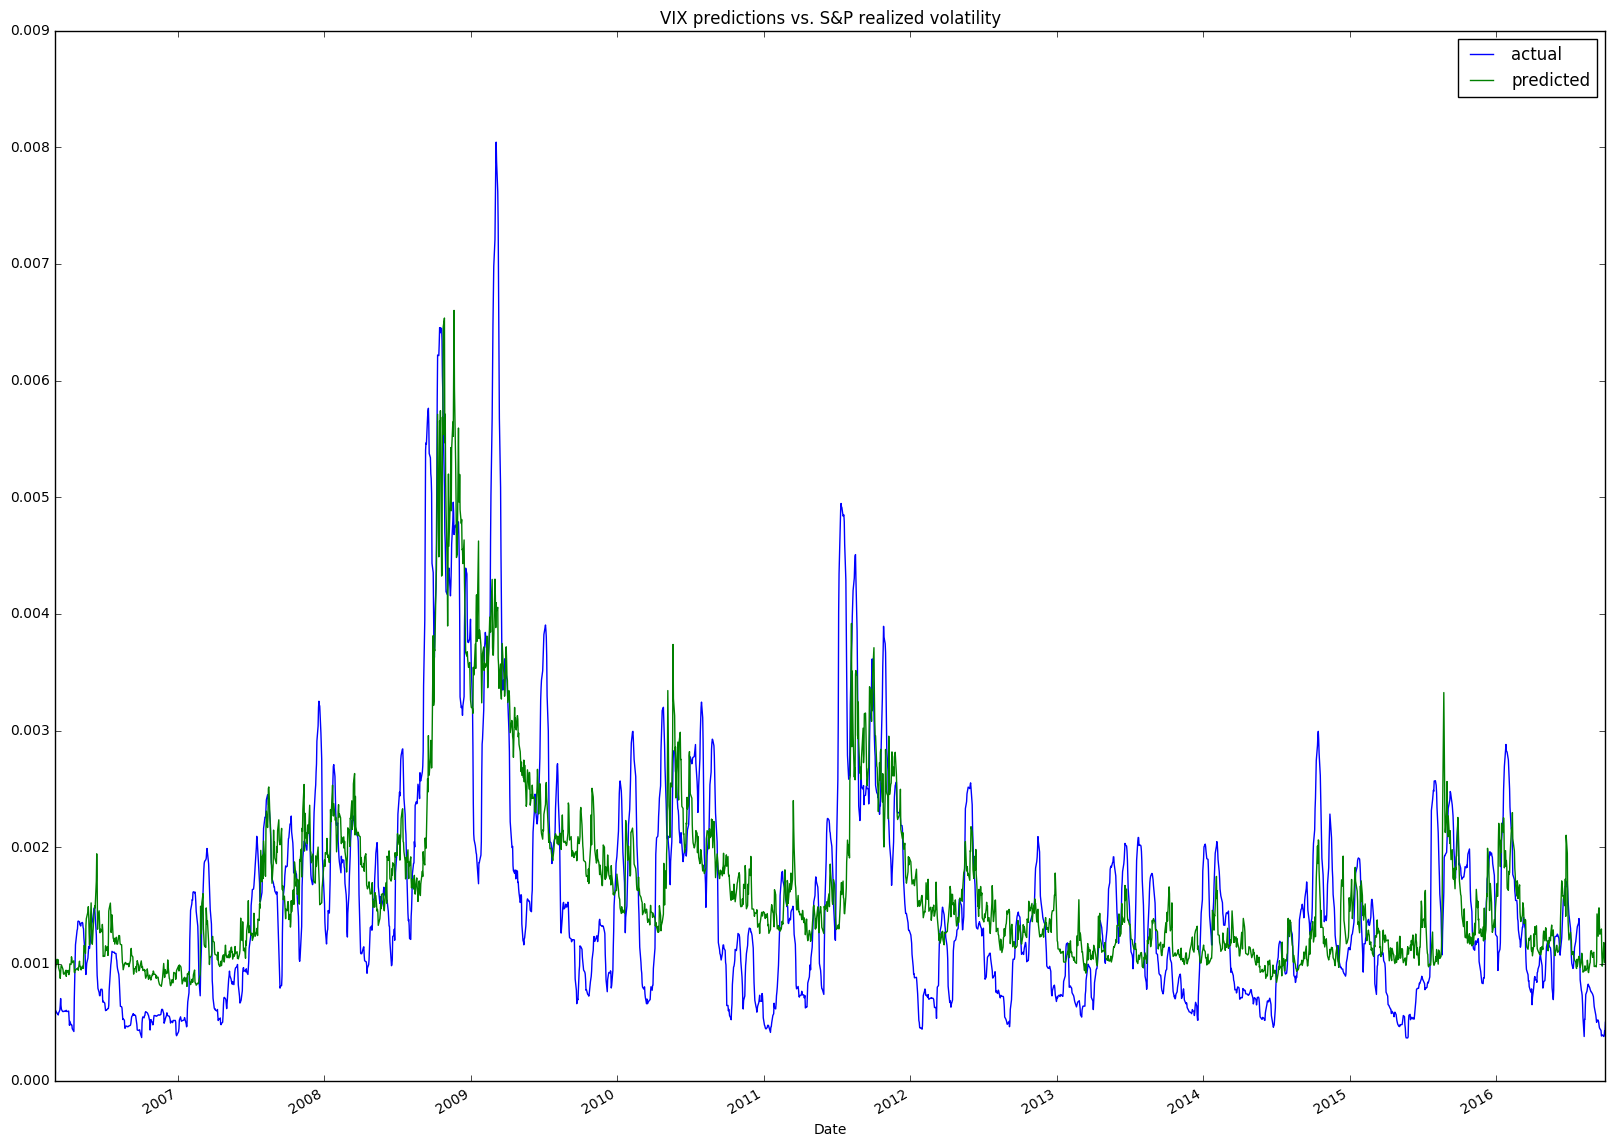

In [9]:
isd = pd.DataFrame()
isd['vix'] = vix.ts.ac
isd['spy'] = spy.vol(22).shift(-22) #monthly volatility shifted by 22 days (# trading days in a month)
isd.dropna(inplace=True)

train = isd[:date(2006,3,1)]
test = isd[date(2006,3,2):]

def vector2mat(vec):
    return np.reshape(vec.values,(vec.values.shape[0],1))

train_spy = vector2mat(train.spy)
train_vix = vector2mat(train.vix)
test_vix = vector2mat(test.vix)
test_spy = vector2mat(test.spy)

linreg = LR_model(train_vix,train_spy)

prediction = linreg.predict(test_vix)
error_df,rmse = compute_rmse(test_spy, prediction)

isd_comp=pd.DataFrame()
isd_comp['actual'] = test.spy
isd_comp['predicted'] = prediction
isd_comp['error'] = error_df
isd_comp.error.plot(title="Squared differences of VIX predictions and S&P realized volatility")

print 'R^2:', linreg.r_squared()

isd_comp[['actual','predicted']].plot(title="VIX predictions vs. S&P realized volatility")
plt.show()

Anecdotally speaking, an $R^2$ of 0.82 implies a strong relationship (especially since we excluded 2008 from the training set!) between the dependent and independent variables.  This tells us that the market prices in future volatility fairly accurately through the VIX. Now that we know there's a predictive relationship between these two series, the natural next step is to figure out under what conditions the VIX mispredicts future volatility. 

### Application: Volatility Arbitrage

If we can systematically characterize the conditions underlying VIX prediction errors, then we might be able to take positions in the market based on our understanding of the mispricing. For example, if we notice that $VIX_t < SPY_{t+22}$ when Apple announces a new phone, then we can implement a trading strategy that profits between the difference of the expected volatility ($VIX_t$) and the realized volatility in the future ($SPY_{t+22}$). In particular, we would buy options on `SPY` that expire in a month and utilize them as described in the `MSFT` example above. 

Now that we know what's going on, let's take a look at the distribution of the top decile of errors from our regression. 

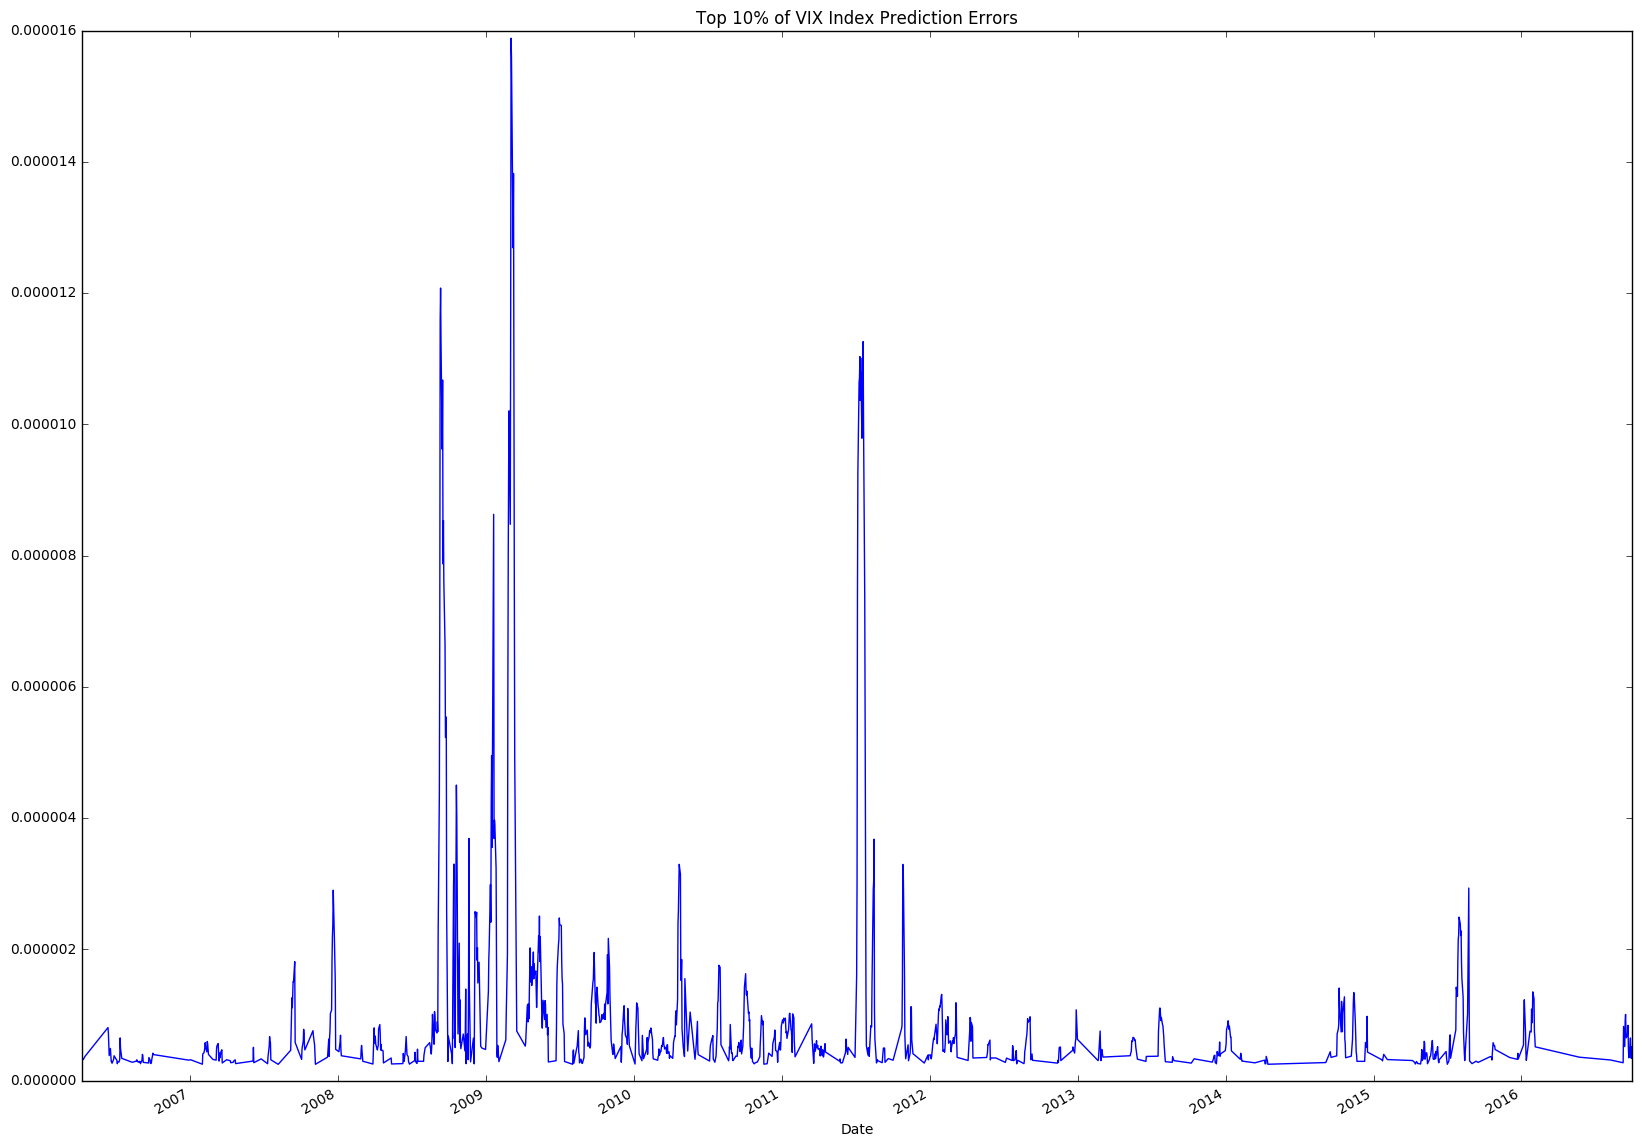

In [25]:
top_decile = isd_comp.error[isd_comp.error - isd_comp.error.quantile(0.6)>0]
top_decile.plot(title='Top 10% of VIX Index Prediction Errors')
plt.show()

This chart looks prettty similar to the VIX itself! Let's compare it to the top 50% of VIX:

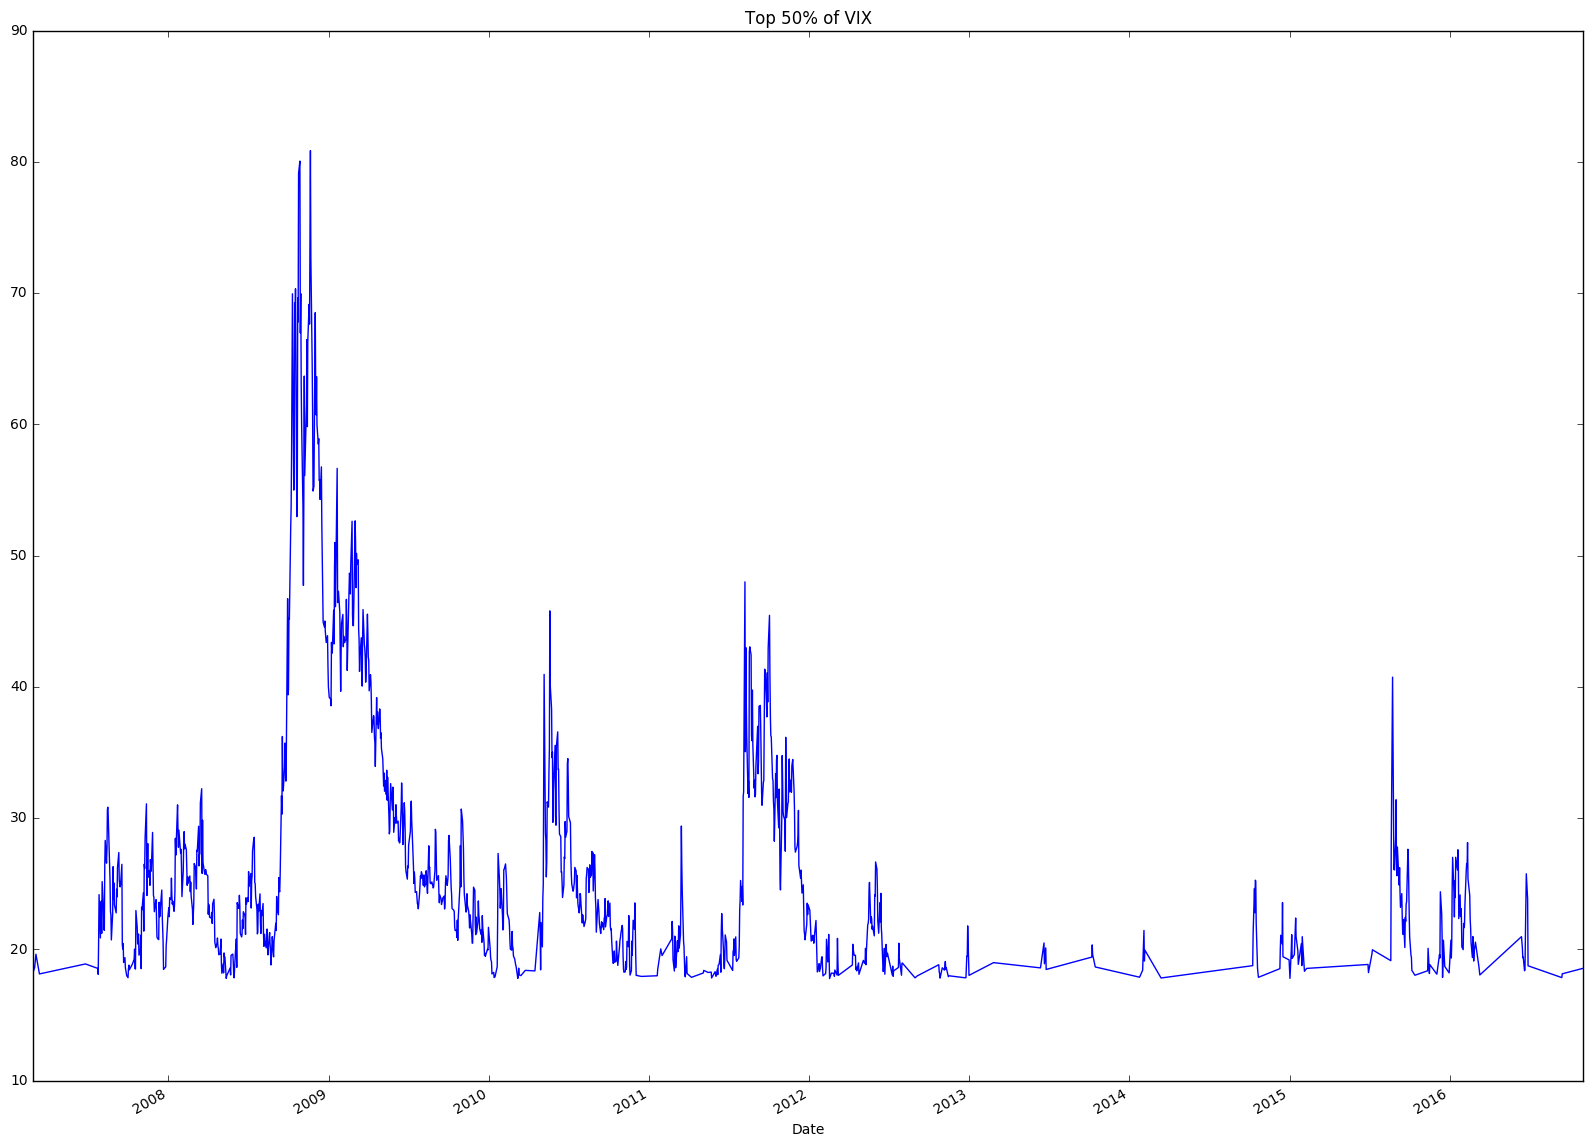

In [11]:
top_vix = vix.ts.ac[vix.ts.ac-vix.ts.ac.quantile(0.5)>0]
top_vix[date(2007,1,1):].plot(title='Top 50% of VIX')
plt.show()

There seems to be an association! It looks like the VIX under predicts volatility when it spikes. In other words, when the market thinks something bad is going to happen, it underestimates how bad that thing is. 

We can regress all VIX values against the 10% of VIX prediction errors from our earlier regression to find the exact $\beta$ that relates $VIX_t$ to the prediction error (call it $E_t$). Let's be cautious here and use the raw error (so that we can distinguish positive/negative error) as our dependent variable.

In [24]:
err_raw = test_spy - prediction #positive error <==> underprediction
isd_comp['err_raw'] = err_raw
isd_comp.err_raw = isd_comp.err_raw[isd_comp.err_raw - isd_comp.err_raw.quantile(0.1)>0]
top_vix = vix.ts.ac[vix.ts.ac-vix.ts.ac.quantile(0.5)>0]
stop = date(2009,1,1)
err_vix_comp =  pd.concat([top_vix,isd_comp.err_raw],axis=1).dropna()
print 'Correlation Matrix (ac is VIX)\n\n', err_vix_comp.corr(),'\n'
linreg2 = LR_model(vector2mat(err_vix_comp.ac[:stop]), vector2mat(err_vix_comp.err_raw[:stop]))
pred = linreg2.predict(err_vix_comp.ac[stop:])
print 'R^2:', linreg2.r_squared()
print 'Beta:', linreg2.beta[0][0]
plt.show()

Correlation Matrix (ac is VIX)

               ac   err_raw
ac       1.000000  0.178723
err_raw  0.178723  1.000000 

R^2: 0.919233234842
Beta: 5.57751473448e-06


There's a positive beta and correlation between spikes in the VIX and prediction errors. This confirms our hypothesis from earlier. So how do we make this insight tradable? 

1. Assume that at each timestep $t$ we receive a new VIX value, $VIX_t$, from our market data stream.
2. Say that we maintain a max-heap $H$ containing $\lfloor \frac{t}{2} \rfloor$ of the largest seen VIX values. 
3. For each $VIX_t$ received, update $H$ as follows: 
    * $VIX_t > \min H \to$ insert $VIX_t$ into the heap. 
        * This is the positive signal for our strategy to buy options on the S&P (recall that options are priced in terms of volatility). 
    * $VIX_t \le \min H \to$ record $VIX_t$ 
         * This is the negative signal for our strategy (we don't take any action).
         
4. If our predictions are sufficiently stable, we can expect to collect a profit by selling our options before expiration for more than what we paid. 

This type of strategy is called volatility arbitrage. 

### Summary and References

1. Lazard Asset Management: http://www.lazardnet.com/docs/sp0/22430/predictingvolatility_lazardresearch.pdf
2. Blair et al: http://citeseerx.ist.psu.edu/viewdoc/download?rep=rep1&type=pdf&doi=10.1.1.205.2367
3. Chicago Board Options Exchange (CBOE) VIX white paper: https://www.cboe.com/micro/vix/vixwhite.pdf
4. _Options, Futures, and other Derivatives_ by John Hull^.
5. NYU V-Lab on GARCH: https://vlab.stern.nyu.edu/doc/2?topic=mdls
6. Quantopian: https://blog.quantopian.com/predicting-volatility-by-dr-ernest-chan/
7. Max Dama on Algorithmic Trading^: http://www.decal.org/file/2945

^ = Great introductory texts
